In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.patches as mp
import seaborn as sns

In [33]:
import numpy as np
import pandas as pd

In [34]:

from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [36]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [41]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [42]:
# Using the inspector to print the column names within the 'Salaries' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [43]:
# Use `engine.execute` to select and display the first 5 rows from the measurement table
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [44]:
# Using the inspector to print the column names within the 'Salaries' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [45]:
# Use `engine.execute` to select and display the first 5 rows from the station table
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [46]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [47]:
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date


('2017-08-23')

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

prcp_last12m = session.query(Measurement.date, func.sum(Measurement.prcp)).\
                    filter(Measurement.date >='2016-08-24').\
                    group_by(Measurement.date).\
                    order_by(Measurement.date).all()
prcp_last12m[:10]

[('2016-08-24', 9.329999999999998),
 ('2016-08-25', 0.54),
 ('2016-08-26', 0.09999999999999999),
 ('2016-08-27', 0.31999999999999995),
 ('2016-08-28', 3.0999999999999996),
 ('2016-08-29', 1.46),
 ('2016-08-30', 0.07),
 ('2016-08-31', 3.1799999999999997),
 ('2016-09-01', 0.03),
 ('2016-09-02', 0.25)]

In [49]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_last12m_df = pd.DataFrame(prcp_last12m, columns=['dates', 'precipitation'])
prcp_last12m_df.head()

,dates,precipitation
0,2016-08-24,9.33
1,2016-08-25,0.54
2,2016-08-26,0.10
3,2016-08-27,0.32
4,2016-08-28,3.10


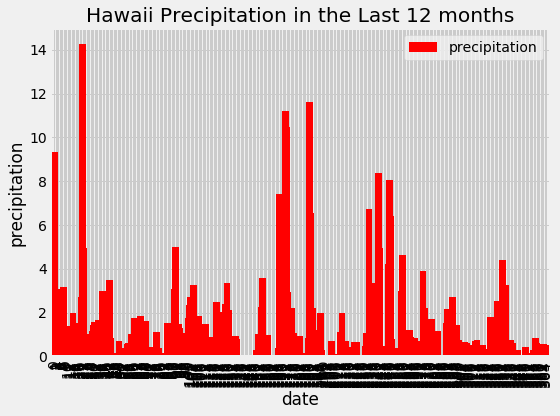

In [50]:

# Use Pandas Plotting with Matplotlib to plot the data

ax = prcp_last12m_df.plot(kind='bar', color = 'r', figsize=(8,6), width = 5)

plt.legend(loc='best')
plt.title('Hawaii Precipitation in the Last 12 months')
plt.xlabel('date')
plt.ylabel('precipitation')
plt.tight_layout()                    
plt.show()


In [51]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_last12m_df.describe()

,precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [52]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(func.count(Station.station)).one()
print("There are total", total_stations[0], "stations.")

There are total 9 stations.


In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                   group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [54]:
print("The moset active station is USC00519281.")

The moset active station is USC00519281.


In [55]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
USC00519281_temp = session.query(Measurement.tobs).\
                    filter(Measurement.station=="USC00519281").\
                    filter(Measurement.date>='2016-08-24').all()
USC00519281_temp_df =pd.DataFrame(USC00519281_temp)

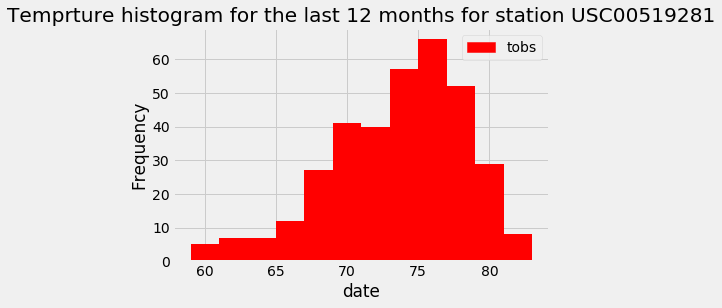

In [56]:
#  plot the results as a histogram
USC00519281_temp_df.plot.hist(bins=12, color ="r", grid = True )
tobs=mp.Patch(color="r", label='tobs')
plt.legend(handles = [tobs])
plt.xlabel('date')
plt.ylabel('Frequency')    
plt.title('Temprture histogram for the last 12 months for station USC00519281')
plt.show()

In [57]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
USC00519281_temp_df.describe()

,tobs
count,351.000000
mean,73.096866
std,4.735491
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


In [58]:
print("The highest temprature is 83, the lowest temprature is 59, the average temprature is 73.09 in station USC00519281.")

The highest temprature is 83, the lowest temprature is 59, the average temprature is 73.09 in station USC00519281.


In [59]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

last_year_temp = calc_temps('2016-08-24', '2017-08-23')
last_year_temp



[(58.0, 74.57894736842105, 87.0)]

In [60]:
last_year_temp_min=58.0
last_year_temp_avg=74.57
last_year_temp_max=87.0

Text(0, 0.5, 'Temp(F)')

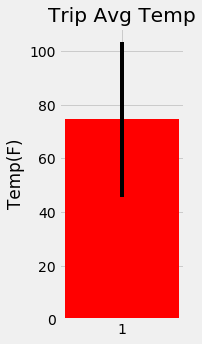

In [61]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar("1", last_year_temp_avg,color="r", yerr = last_year_temp_max-last_year_temp_min)
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")

In [62]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_per_station = session.query(Measurement.station, func.sum(Measurement.prcp)).\
                   filter(Measurement.date >= '2016-07-01').\
                   filter(Measurement.date <= '2016-12-31').\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()

        
print("Total Rainfall During the Vacation")
for station, rainfall in prcp_per_station:
    print(f"Station: {station}, Toral Rainfall: {rainfall}.")

Total Rainfall During the Vacation
Station: USC00516128, Toral Rainfall: 115.39000000000003.
Station: USC00519281, Toral Rainfall: 53.14000000000001.
Station: USC00513117, Toral Rainfall: 30.520000000000014.
Station: USC00519523, Toral Rainfall: 18.959999999999997.
Station: USC00514830, Toral Rainfall: 15.289999999999988.
Station: USC00519397, Toral Rainfall: 12.909999999999997.
Station: USC00517948, Toral Rainfall: 1.8900000000000003.
